# POLYGRAPHS BOOTCAMP - SESSION 3: Temporal Networks

## Introduction 

### What are temporal networks?

<span style="font-size: 16px;"> Simply speaking, temporal networks are networks that vary over time. This means that, unlike static networks, the connections (or _edges_) between the nodes are not fixed but evolve dynamically, allowing edges to appear, disappear, and reappear over time.  The use of temporal networks offers a more nuanced understanding of complex systems, allowing to see how these systems develop, change, and evolve over time. This approach is advantageous across various fields and can enhance our understanding of many real-world phenomena - from the transmission of infectious behaviors to the dynamics of beliefs spread within social networks.

### Statics vs Temporal 
<span style="font-size: 16px;"> Let's compare, for instance, two different networks created from the same dataset:


<img src="pic1.png" alt="Alt Text" width="800"/>

<p style="text-align: center;"> The left figure illustrates a static network representing who is friends with who. Each person is a circled node, and and the edges connecting them indicate friendships.  The right figure shows a temporal network showing the progression o who met who and when. For instance, we known from the static network that everyone has met everyone except Dylan (orange) and Casey (light green) but we have no clue about the time-point of these meetings, which are instead captured by the temporal network. (e.g. that Ashley and Blake met at event 1 and at event 3, Blake met Dylan). </p> 

 Source: https://teneto.readthedocs.io/en/latest/what_is_tnt.html

### Timestamps 

<span style="font-size: 16px;"> The key caractheristic of a temporal network is the temporal dimension, which is represented by including a timestamp in the edges. Binary edges are typically expressed as 3-tuples (source, destination, timestamp) and weighted edges as 4 tuples (source, destination, timestamp, weight). While timestamps are always arranged in an ordered sequence, there are various ways of measuring and tracking temporality. The chosen approach will ultimately depends on many factors, such as the nature of the interactions being analyzed, the purpose of the reaserchers, and the study requirement.  

<span style="font-size: 16px;"> Today, we will see how to run simulation in Polygraphs on temporal networks, where time is measured by either one of two units - _months_ and _weeks_ - and is specified as Unix timestamp.*

*The Unix timestamps represent the number of seconds that have passed since January 1, 1970 (known as the Unix epoch) and is a common metrics for date and time representation in computer science.

# Running Simulations with Polygraphs

<span style="font-size: 16px;">  In the previous sessions, you learned how to run simulations in Polygraphs using configuration files for both existing and custom graphs. While the Internet provides a wealth of graphs suitable for research, there may be instances where you only have datasets available or where you plan to collect new data for your simulations.

<span style="font-size: 16px;">  In this session, we will first explore how to create a graph from an existing dataset and then demonstrate how to run Polygraphs on it.

### The Dataset

<span style="font-size: 16px;"> We will create graphs from the dataset 'CollegeMsg' available from the SNAP repository: http://snap.stanford.edu/data/index.html

You can download it from this link: https://snap.stanford.edu/data/CollegeMsg.html

<span style="font-size: 16px;"> The dataset consists of private messages sent on an online social network at the University of California, Irvine during a time span of 193 days. 

### From Datasets to (Temporal) Graphs 

In [1]:
#set up
_DATACACHE = "~/polygraphs-cache/data"
#!pip install polygraphs  

In [2]:
#import libraries 
import sys
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt

<span style="font-size: 16px;"> Let's start by having a look inside the file by printing the first five lines:

In [3]:
# Open the text file in read mode
input_file = '/Users/mariafedericanorelli/Desktop/humannetworkscience/datasets/CollegeMsg.txt'
with open(input_file, 'r') as file:
    # Read the first line
    first_five_lines = [file.readline().strip() for _ in range(5)]
    print(first_five_lines)

['1 2 1082040961', '3 4 1082155839', '5 2 1082414391', '6 7 1082439619', '8 7 1082439756']


<span style="font-size: 16px;"> We have a list of tuples, each corresponding to an edge, representing a message sent from the source node (user) to the target node (user) at a specific time. This is saved in a plain txt file but Polygraphs requires (and it is always a good practice working with) structured data in a tabular layout, so to make it easier to process and manipulate. In order to do so, we have to import from the given Polygraphs module for converting txt file to csv and open it:

In [4]:
from polygraphs.datasets.fromData2Graphs import txt_to_csv, read_csv
#convert from txt to csv  
output_file = '/Users/mariafedericanorelli/Desktop/humannetworkscience/datasets/CollegeMsg.csv'
txt_to_csv(input_file, output_file)

Conversion completed. CSV file saved at: /Users/mariafedericanorelli/Desktop/humannetworkscience/datasets/CollegeMsg.csv


In [5]:
#read it 
messages, source, dest, timestamps = read_csv(output_file, source_column_name = 'SRC', destination_column_name= 'DST', timestamp_column_name='timestamp') 

messages.head()

,SRC,DST,timestamp
0,3,4,1082155839
1,5,2,1082414391
2,6,7,1082439619
3,8,7,1082439756
4,9,10,1082440403


<span style="font-size: 16px;"> In this dataset, each row represents an edge in the graph. The first column identifies the source node (the sender of the message), the second column denotes the destination node (the receiver), and the third column contains the timestamp indicating when the message was sent. Now that we understand the structure of our data, we are ready to create our graph. However, before proceeding, let’s consider an alternative scenario in which we wanto to fetch the dataset remotely from the URL, without firstly dowloading it locally. Again, we have to import the dedicated function:

In [6]:
from polygraphs.datasets.fromData2Graphs import fetch_file
destination_folder = '/Users/mariafedericanorelli/Desktop/humannetworkscience/datasets'
origin = 'https://snap.stanford.edu/data/CollegeMsg.txt.gz'
online_file = fetch_file(origin, destination_folder)

online_messages, online_source, online_destination, online_timestamps  = read_csv(online_file, source_column_name = 'SRC', destination_column_name= 'DST', timestamp_column_name='timestamp') 

online_messages.head()

,SRC,DST,timestamp
0,3,4,1082155839
1,5,2,1082414391
2,6,7,1082439619
3,8,7,1082439756
4,9,10,1082440403


<span style="font-size: 16px;"> Let's call now the functions to create the graph, normalize it and save it.*
To provide a comprehensive view of the network dynamics, we will generate both a static and a temporal graph and compare them.

*We normalize the nodes data in order to make our analysis comparable across different graphs or datasets. Normalizing to a common scale (i.e. 0 to 1) also ensures that all attributes are on a common scale. This is particularly important when node values represent different metrics (e.g., weights, degrees, centrality measures) that may have different units or ranges. By normalizing these values, Polygraphs makes it easier to compare and analyze nodes effectively.

In [7]:
from polygraphs.datasets.fromData2Graphs import create_graph, create_temporal_graph, normalize_graph, save_graph

<span style="font-size: 16px;"> For the static version of the graph can simply avoid calling the variable 'timestamps' when creating it. 


In [8]:
#create the graph 
G_static = create_graph (source, dest)

#normalize it
normalized_graph_static = normalize_graph(G_static)

#save graph
destination_folder = '/Users/mariafedericanorelli/Desktop/humannetworkscience/graphs'
save_graph( normalized_graph_static, "gml", destination_folder, 'College_Message_SG')

The graph has 1899 nodes and 20295 edges
Graph saved as /Users/mariafedericanorelli/Desktop/humannetworkscience/graphs/College_Message_SG.gml


<span style="font-size: 16px;"> Let's visualize a specific segment of the graph (e.g. the first 100 edges)


Subgraph saved as Static_Messages.png


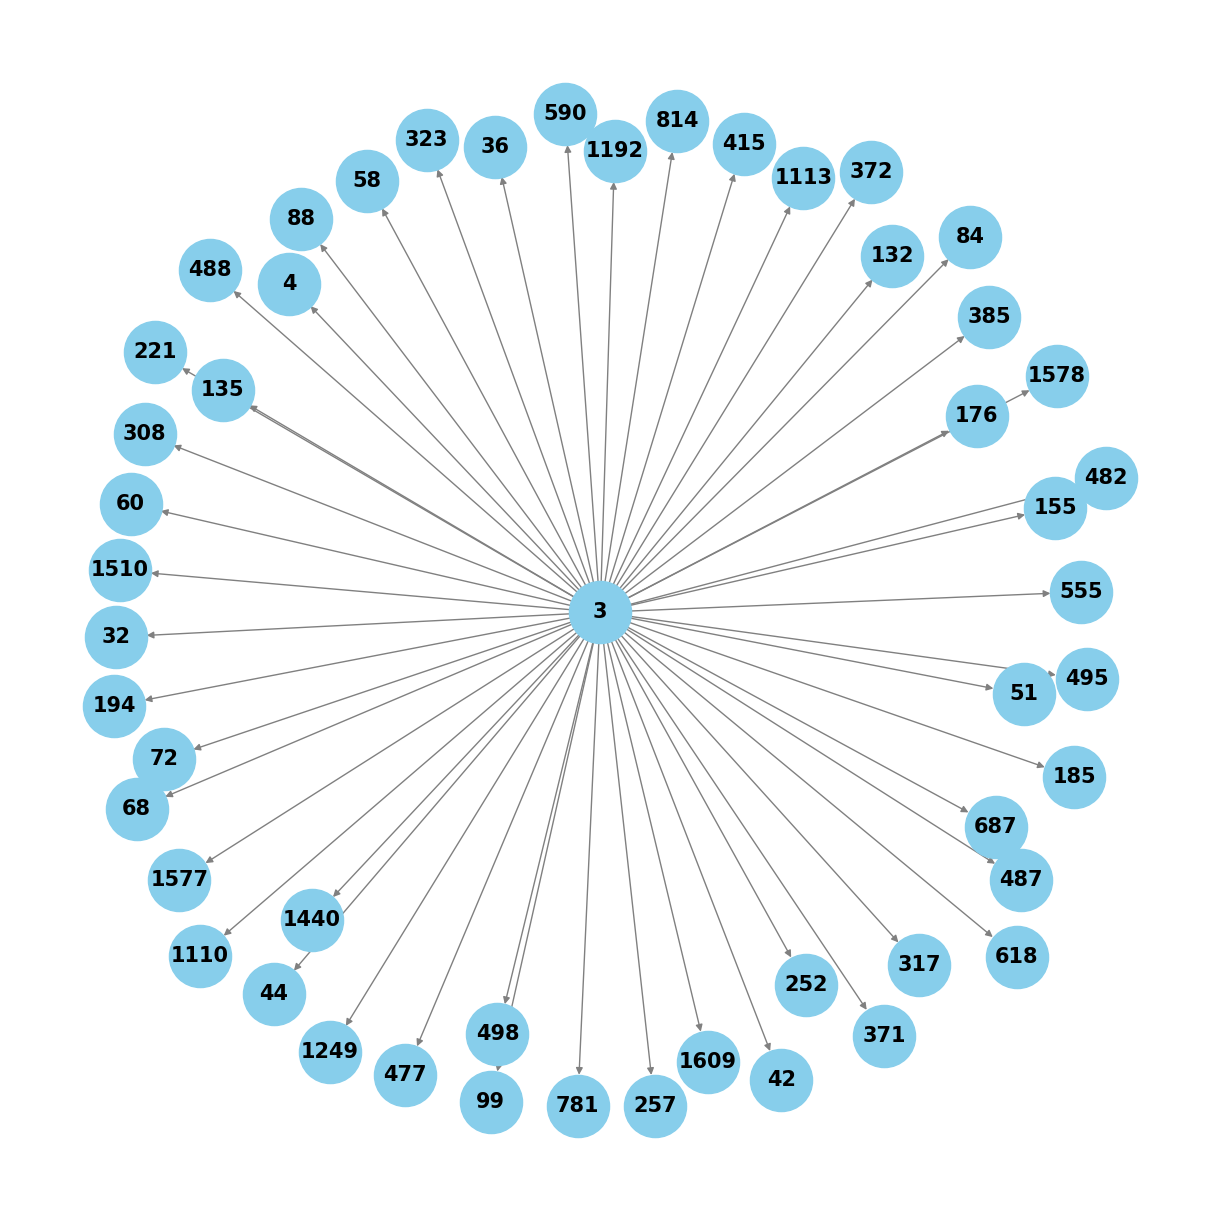

In [9]:
#plot the graph 
from polygraphs.datasets.fromData2Graphs  import print_graph_details

print_graph_details(normalized_graph_static, num_edges=50, output_file="Static_Messages.png")

<span style="font-size: 16px;"> To effectively build a temporal graph, we choose to use the timestamp data to create subgraphs that represent snapshots of the network at different time intervals (i.e. weeks or months). The subgraphs are ordered in sequence based on the timestamps associated with the nodes. Creating subgraphs ordered by time enables us to analyze segments of the network at defined intervals, where each subgraph represents the state of the network during a particular time slice. For this dataset, the edges represent interactions that occur at specific time points. By ordering these interactions based on their timestamps, we can observe how relationships evolved over time.

In [10]:
#create the graph
G = create_temporal_graph(source, dest, timestamps)

#normalize it
normalized_graph = normalize_graph(G)

#save it 
save_graph( normalized_graph, "gml", destination_folder, 'College_Message_NG')


The temporal graph has 1899 nodes and 20295 edges
Graph saved as /Users/mariafedericanorelli/Desktop/humannetworkscience/graphs/College_Message_NG.gml


In [11]:
# check for Unix timestamps 
counter = 0  # Initialize a counter to limit the output
max_edges = 4  # Set the maximum number of edges you want to print

print("Inspecting edge attributes...")

for u, v, data in normalized_graph.edges(data=True):
    print(f"Edge from {u} to {v} - Attributes: {data}")
    
    # Check if 'timestamp' is present in the edge attributes
    timestamp = data.get('timestamp')
    if timestamp is not None:
        print(f"Edge ({u}, {v}) - Timestamp: {timestamp}")
    else:
        print("No timestamp found in this edge.")
        
    counter += 1  # Increment the counter
    if counter >= max_edges:  # Stop if the counter reaches the limit
        break

Inspecting edge attributes...
Edge from 3 to 4 - Attributes: {'timestamp': 1082155839}
Edge (3, 4) - Timestamp: 1082155839
Edge from 3 to 84 - Attributes: {'timestamp': 1082624696}
Edge (3, 84) - Timestamp: 1082624696
Edge from 3 to 155 - Attributes: {'timestamp': 1088378565}
Edge (3, 155) - Timestamp: 1088378565
Edge from 3 to 58 - Attributes: {'timestamp': 1082751801}
Edge (3, 58) - Timestamp: 1082751801



Subgraph saved as Temporal_Messages.png


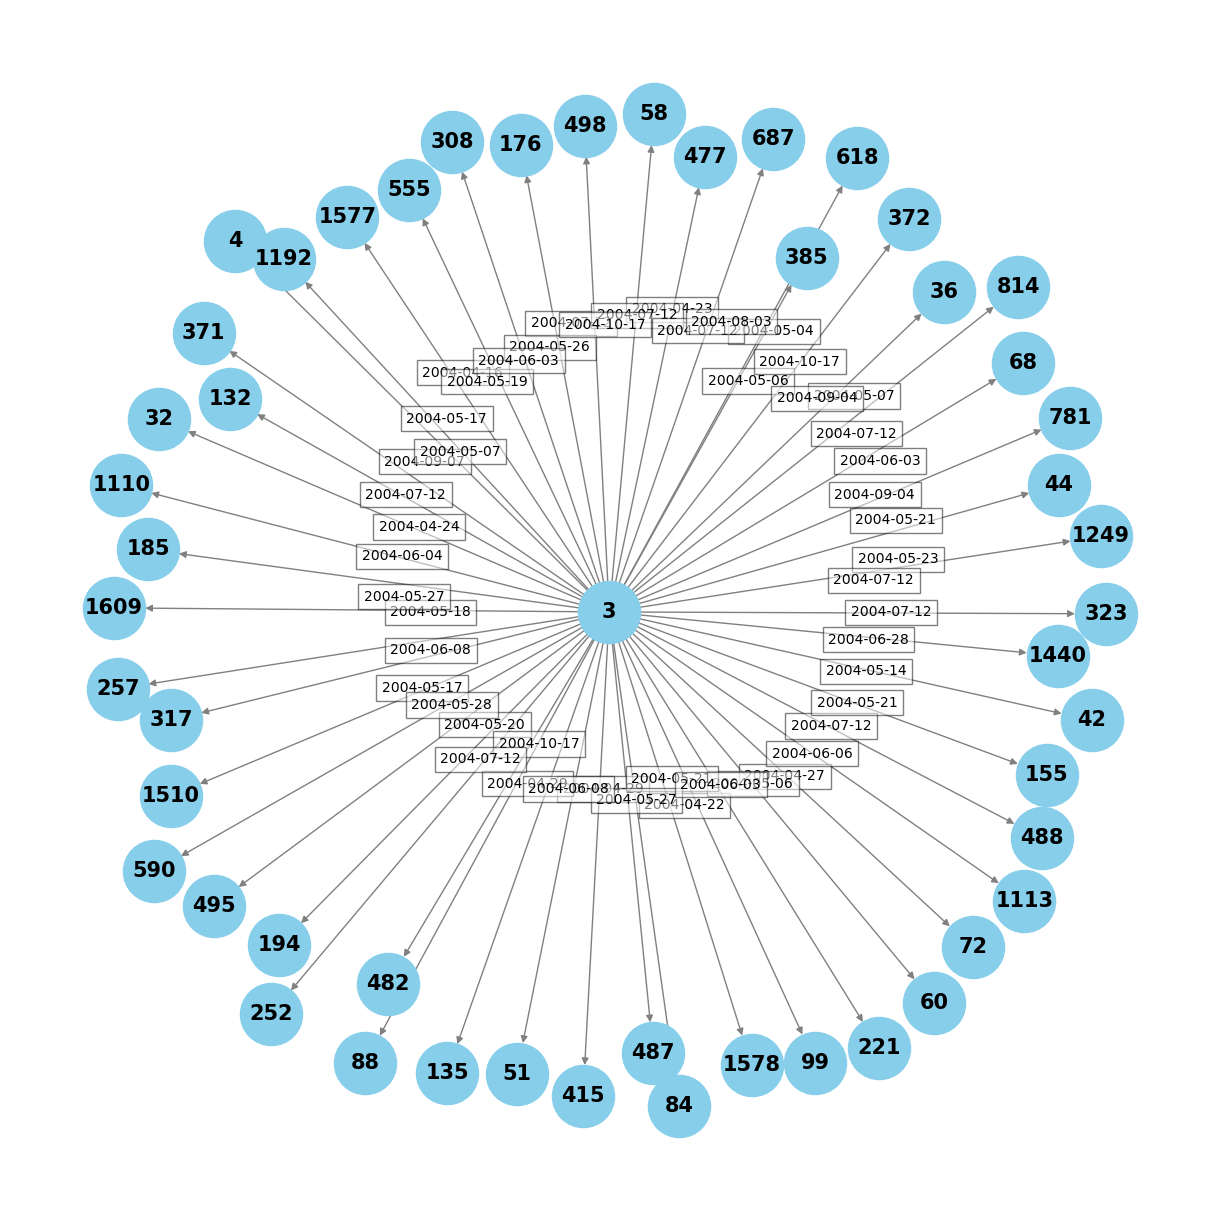

In [12]:
#plot the graph 
from polygraphs.datasets.fromData2Graphs  import print_graph_details

print_graph_details(normalized_graph, num_edges=50, output_file="Temporal_Messages.png")

### Run the Simulations

<span style="font-size: 16px;"> In Polygraphs, we run simulation on graphs using a configuration file with specific parameters. To adapt the software to temporal networks, we will run simulations on these subgraphs so that, for each subgraph, the simulation will run for a specified number of steps before switching to the next subgraph. Since we want temporal continuity between simulations, each interval's simulation should continue from where the previous one left off. This means that the beliefs (node states) at the end of one simulation should be the starting beliefs for the next interval's simulation.

We need to add a new parameter 'interval' to our configuration file to specify the interval for subgraph creation. Recall you can choose 'week'or 'month'.




In [13]:
#static graph conf file
conf_path_S = '/Users/mariafedericanorelli/Desktop/humannetworkscience/polygraphs/configs/College_Message_SG.yaml'
#simulate
!polygraphs -f "{conf_path_S}"

No timestamps found, running as a static graph without temporal information.
Beliefs at step 1: A/B = 918/982
[MON] Interval None: step 0001 Ksteps/s   0.00 A/B 0.48/0.52
Beliefs at step 50: A/B = 230/1670
[MON] Interval None: step 0050 Ksteps/s   0.05 A/B 0.12/0.88
Beliefs at step 100: A/B = 139/1761
[MON] Interval None: step 0100 Ksteps/s   0.05 A/B 0.07/0.93
Beliefs at step 150: A/B = 82/1818
[MON] Interval None: step 0150 Ksteps/s   0.05 A/B 0.04/0.96
Beliefs at step 200: A/B = 60/1840
[MON] Interval None: step 0200 Ksteps/s   0.05 A/B 0.03/0.97
Beliefs at step 250: A/B = 41/1859
[MON] Interval None: step 0250 Ksteps/s   0.05 A/B 0.02/0.98
Beliefs at step 300: A/B = 26/1874
[MON] Interval None: step 0300 Ksteps/s   0.05 A/B 0.01/0.99
 INFO polygraphs> Sim #0001:    300 steps    6.32s; action: ? undefined: 0 converged: 0 polarized: 0 
Bye.


In [14]:
#temporal configuration file
conf_path = '/Users/mariafedericanorelli/Desktop/humannetworkscience/polygraphs/configs/College_Message.yaml'

##let's do a check of the interval parameters
# Add the path to polygraphs module
sys.path.append('/Users/mariafedericanorelli/Desktop/humannetworkscience/polygraphs')

# test_yaml_loading.py
from polygraphs.hyperparameters import PolyGraphHyperParameters

# see is the interval is the one we want 
params = PolyGraphHyperParameters.fromYAML(conf_path)

print("Interval loaded from config:", params.interval)

Interval loaded from config: month


In [15]:
#simulatation 
!polygraphs -f "{conf_path}"

Timestamps added to the graph.
Total edges: 40418
Created subgraph for interval 2004-04: 2992 edges.
Graph ID for interval 2004-04: 6975324432
SubGraph ID for interval 2004-04: 4951838288
Edge (3, 4) - Timestamp: 1082155839
Edge (3, 84) - Timestamp: 1082624696
Edge (3, 58) - Timestamp: 1082751801
Edge (3, 185) - Timestamp: 1082832584
Edge (3, 221) - Timestamp: 1083040089
Created subgraph for interval 2004-05: 24304 edges.
Graph ID for interval 2004-05: 6975324432
SubGraph ID for interval 2004-05: 7068792976
Edge (3, 132) - Timestamp: 1083900742
Edge (3, 618) - Timestamp: 1083655411
Edge (3, 99) - Timestamp: 1083808953
Edge (3, 385) - Timestamp: 1083809094
Edge (3, 814) - Timestamp: 1083901316
Created subgraph for interval 2004-06: 6506 edges.
Graph ID for interval 2004-06: 6975324432
SubGraph ID for interval 2004-06: 7067912144
Edge (3, 155) - Timestamp: 1088378565
Edge (3, 1577) - Timestamp: 1086234548
Edge (3, 1578) - Timestamp: 1086233742
Edge (3, 781) - Timestamp: 1086291360
Edge (

### Results Analysis

In [16]:
# Load the temporal simulation data from the specified directory
#dataN_path = "/Users/mariafedericanorelli/polygraphs-cache/results/2024-10-09/ee69044238ac457fbe56ea631f3b899f/data.csv" 
#dataN = pd.read_csv(dataN_path)  # Adjust if your file format is different
#dataN

In [17]:
# Load the static simulation data from the specified directory
#dataR_path = "/Users/mariafedericanorelli/polygraphs-cache/results/2024-10-09/eb166d24f945411e9af3a2abd4788f0f/data.csv" 
#dataR = pd.read_csv(dataR_path)  # Adjust if your file format is different
#dataR

In [18]:
#import the simulation data
from polygraphs.analysis import Processor

processor = Processor()


/Users/mariafedericanorelli/anaconda3/lib/python3.11/site-packages/polygraphs/analysis/simulation_processor.py:197: UserWarning: Number of rows in data.csv did not match bin and hd5 files: /Users/mariafedericanorelli/polygraphs-cache/results/2024-10-10/c89746b2db2f4117b256bc2bd30380f2
  warnings.warn(
/Users/mariafedericanorelli/anaconda3/lib/python3.11/site-packages/polygraphs/analysis/simulation_processor.py:197: UserWarning: Number of rows in data.csv did not match bin and hd5 files: /Users/mariafedericanorelli/polygraphs-cache/results/2024-10-10/5bcebc1ab8184c1d8142e1658213e4f7
  warnings.warn(


In [19]:
from polygraphs.analysis import Processor

processor = Processor()
#entry = dataR.iloc[0]
_ = processor.beliefs[1].groupby("iteration")

fig, ax = plt.subplots()

ax.plot(_.mean(), label='Mean')
ax.plot(_.median(), label='Median')
ax.plot(_.min(), label='Min')
ax.plot(_.max(), label='Max')
ax.plot(_.quantile(.25), label='25th Quantile')
ax.plot(_.quantile(.01), label='01th Quantile')

ax.set_ylim(0, 1.05)
ax.set_xlabel('Iteration')
ax.legend()

# Set the limits for the y-axis
ax.set_ylim(0, 1.05)

# Title for the plot (optional)
ax.set_title('Belief Statistics Over Iterations')

# Show the plot
plt.show()


/Users/mariafedericanorelli/anaconda3/lib/python3.11/site-packages/polygraphs/analysis/simulation_processor.py:197: UserWarning: Number of rows in data.csv did not match bin and hd5 files: /Users/mariafedericanorelli/polygraphs-cache/results/2024-10-10/c89746b2db2f4117b256bc2bd30380f2
  warnings.warn(
/Users/mariafedericanorelli/anaconda3/lib/python3.11/site-packages/polygraphs/analysis/simulation_processor.py:197: UserWarning: Number of rows in data.csv did not match bin and hd5 files: /Users/mariafedericanorelli/polygraphs-cache/results/2024-10-10/5bcebc1ab8184c1d8142e1658213e4f7
  warnings.warn(


IndexError: Simulation index out of range